This notebook goes through the entire process of our participation in the AICrowd challenge Road Segmentation. The notebook should be seen as a complement to the final report.

### Imports and setup

This section handles the necessary imports and setup for the notebook.

In [1]:
# Mounts drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing the segmentation models for Keras library

In [ ]:
pip install -U segmentation-models

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
sm.set_framework('tf.keras')
import os
import matplotlib.image as mpimg
from PIL import Image
import cv2
from seg_mod_unet.data_handling import extract_data, extract_data_test, extract_labels
from seg_mod_unet.helpers import patch_to_label, window_predict, img_float_to_uint8, save_predictions, masks_to_submission
import math
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# setting the style for plots using seaborn
sns.set()
sns.set_style("white")

### Extracting data and masks

Unzipping the data folders for quick access in Colab

In [ ]:
!unzip "/content/drive/My Drive/ml/data.zip" -d "/content"

In [ ]:
!unzip "/content/drive/My Drive/ml/testing.zip" -d "/content"

In [6]:
# Defining paths to images and masks
train_data_path = '/content/data/training/images/'
train_labels_path = '/content/data/training/groundtruth/'

# Extracting the data and masks
x_train = extract_data(train_data_path)
y_train = extract_labels(train_labels_path)

In [7]:
# Splitting the dataset into two, one training set and one validation set
x_val = x_train[1360:]
y_val = y_train[1360:]
x_train = x_train[0:1360]
y_train = y_train[0:1360]

### Model

In [8]:
# defining backbone for the model
BACKBONE = 'resnet34'
# downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocessing training and validation data
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [9]:
# defining model, using 'imagenet' as weights to converge faster
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(256, 256, 3))

# adding  L2 kernel regularizer
sm.utils.set_regularization(model, kernel_regularizer=keras.regularizers.l2(1))

# compiling the model using Adam optimizer and Binary Cross Entropy with Jaccard loss
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(),'accuracy'],
)

# saving the model thats scores best on the validation data
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/m6.h5", save_best_only=True)]

# training the model for 50 epochs with batch size = 32
history = model.fit(x=x_train, y=y_train,
   epochs=50, batch_size=32,
   callbacks=callbacks,
   validation_data=(x_val,y_val)
)

85532672/85521592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
43/43 [==============================] - 78s 1s/step - loss: 1.0840 - iou_score: 0.3173 - f1-score: 0.4720 - accuracy: 0.6757 - val_loss: 3.7963 - val_iou_score: 8.4665e-09 - val_f1-score: 1.6905e-08 - val_accuracy: 0.7649
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.7195 - iou_score: 0.5270 - f1-score: 0.6897 - accuracy: 0.7358 - val_loss: 2.2874 - val_iou_score: 0.0330 - val_f1-score: 0.0639 - val_accuracy: 0.7649
Epoch 3/50
43/43 [==============================] - 42s 966ms/step - loss: 0.6146 - iou_score: 0.6012 - f1-score: 0.7506 - accuracy: 0.7446 - val_loss: 3.4945 - val_iou_score: 0.0094 - val_f1-score: 0.0187 - val_accuracy: 0.7649
Epoch 4/50
43/43 [==============================] - 41s 964ms/step - loss: 0.5686 - iou_score: 0.6349 - f1-score: 0.7764 - accuracy: 0.7489 - val_loss: 3.7957 - val_iou_score: 1.2973e-06 - val_f1-score: 2.5945e-06 - val_accuracy: 0.7649
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.

Visualizing results

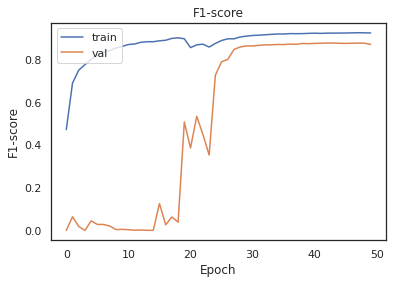

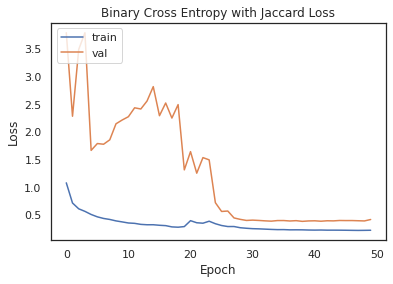

In [23]:
# F1-score for the model across epochs
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('f1_score.png')
plt.show()

# Loss for the model across epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy with Jaccard Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

### Testing

In [ ]:
# loading the best model for predictions
model = load_model('/content/drive/MyDrive/Models/m5.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

In [15]:
# generating predictions on the validation set
y_pred = model.predict((x_val))

# defining patch_size to be used in predictions
patch_size = 16

Using validation set to find optimal threshold for defining a patch as road

In [17]:
# defining a list of potential thresholds
thresholds = [0.01*i for i in range(0, 101)]
# list for saving f1-scores
f1s = []
# saving highest f1-score 
highest = 0

# iterating through each threshold and calculating F1-score and accuracy
for thr in thresholds:

  # converting pixelwise predictions to patchwise predictions
  y_pred_flattened = []
  for im in y_pred:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_pred_flattened.append(label)
  y_pred_flattened = np.array(y_pred_flattened)

  # converting mask to patchwise values
  y_val_flattened = []
  for im in y_val:
    for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              label = patch_to_label(patch, thr)
              y_val_flattened.append(label)

  # calculating and storing f1-score and accuracy
  f1 = f1_score(y_val_flattened, y_pred_flattened)
  acc = accuracy_score(y_val_flattened, y_pred_flattened)
  f1s.append(f1)

  # setting foreground_threshold for future predcitions to thr if thr gives the best f1-score
  if f1>highest:
    foreground_threshold=thr

  print("Threshold: %.2f, F1-score: %.4f, Accuracy: %.4f"%(thr, f1, acc))

Threshold: 0.00, F1-score: 0.5233, Accuracy: 0.3543
Threshold: 0.01, F1-score: 0.9750, Accuracy: 0.9844
Threshold: 0.02, F1-score: 0.9763, Accuracy: 0.9855
Threshold: 0.03, F1-score: 0.9765, Accuracy: 0.9859
Threshold: 0.04, F1-score: 0.9764, Accuracy: 0.9860
Threshold: 0.05, F1-score: 0.9773, Accuracy: 0.9866
Threshold: 0.06, F1-score: 0.9774, Accuracy: 0.9868
Threshold: 0.07, F1-score: 0.9767, Accuracy: 0.9866
Threshold: 0.08, F1-score: 0.9766, Accuracy: 0.9866
Threshold: 0.09, F1-score: 0.9774, Accuracy: 0.9872
Threshold: 0.10, F1-score: 0.9776, Accuracy: 0.9875
Threshold: 0.11, F1-score: 0.9775, Accuracy: 0.9875
Threshold: 0.12, F1-score: 0.9778, Accuracy: 0.9878
Threshold: 0.13, F1-score: 0.9779, Accuracy: 0.9879
Threshold: 0.14, F1-score: 0.9771, Accuracy: 0.9876
Threshold: 0.15, F1-score: 0.9765, Accuracy: 0.9874
Threshold: 0.16, F1-score: 0.9760, Accuracy: 0.9872
Threshold: 0.17, F1-score: 0.9754, Accuracy: 0.9871
Threshold: 0.18, F1-score: 0.9753, Accuracy: 0.9871
Threshold: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Threshold: 0.99, F1-score: 0.0000, Accuracy: 1.0000
Threshold: 1.00, F1-score: 0.0000, Accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Plotting the F1-score by thresholds

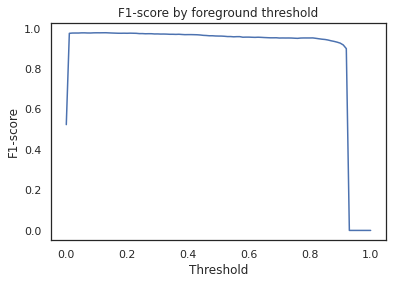

In [22]:
plt.plot(thresholds, f1s)
plt.title("F1-score by foreground threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.savefig("thr.png")
plt.show()

### Predicting

In [ ]:
# extracting the test set
test_images = extract_data_test('/content/testing/')
# preprocessing the test images
test_images = preprocess_input(test_images)

In [ ]:
# generating predictions for the test images
results = []
for img in test_images:
    results.append(window_predict(img, model))

In [ ]:
# generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(img, 'test%d'%i)

Converting the saved images to a final submission file

In [ ]:
# generating the prediction file for the test set
submission_filename = '/content/drive/MyDrive/Pred/model.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = '/content/drive/MyDrive/Pred/test%d.png' % i
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, foreground_threshold, *image_filenames)